In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

dim_customer = pd.read_json('/Users/luismariano/Downloads/dim_customer.json')
fct_invoice  = pd.read_csv('/Users/luismariano/Downloads/fct_invoice.csv')

In [43]:
def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.columns = (
        out.columns.str.strip()
                    .str.replace(r'\s+', '_', regex=True)
                    .str.replace(r'[^0-9A-Za-z_]', '', regex=True)
                    .str.lower()
    )
    return out

dim_customer = normalize_cols(dim_customer)
fct_invoice  = normalize_cols(fct_invoice)

req_dim_cols = {'id','age'}
req_inv_cols = {'customer_id','category','quantity','price','payment_method','invoice_date'}

missing_dim = req_dim_cols - set(dim_customer.columns)
missing_inv = req_inv_cols - set(fct_invoice.columns)
assert not missing_dim, f"Missing in dim_customer: {missing_dim}"
assert not missing_inv, f"Missing in fct_invoice: {missing_inv}"

fct_invoice['invoice_date'] = pd.to_datetime(fct_invoice['invoice_date'], errors='coerce')
fct_invoice['line_total']   = (pd.to_numeric(fct_invoice['quantity'], errors='coerce') * 
                               pd.to_numeric(fct_invoice['price'], errors='coerce'))

## Easy

### Easy 1: How many unique customers are in the dataset?

In [44]:
unique_customers_dim = dim_customer['id'].nunique()
unique_customers_invoices = fct_invoice['customer_id'].nunique()

print("Unique customers in dim_customer:", unique_customers_dim)
print("Unique customers appearing in fct_invoice:", unique_customers_invoices)

Unique customers in dim_customer: 5191
Unique customers appearing in fct_invoice: 5191


### Easy 2: What are the different categories of products available? How many unique categories are there?

In [45]:
cats = (fct_invoice['category']
        .astype(str).str.strip().replace('', np.nan).dropna()
        .unique())
cats = np.sort(cats)
print("Categories:")
for c in cats:
    print(" -", c)
print("\nNumber of unique categories:", len(cats))

Categories:
 - Books
 - Clothing
 - Cosmetics
 - Food & Beverage
 - Shoes
 - Souvenir
 - Technology
 - Toys

Number of unique categories: 8


### Easy 3: Which payment method is the most popular? How many times was it used?

In [46]:
pm_counts = (fct_invoice['payment_method']
             .astype(str).str.strip().replace('', np.nan).dropna()
             .value_counts(dropna=False))
display(pm_counts.to_frame('count'))

if len(pm_counts):
    top_method = pm_counts.index[0]
    top_count  = pm_counts.iloc[0]
    print(f"\nMost popular payment method: {top_method} (used {top_count} times)")
else:
    print("No payment method data found.")

,count
payment_method,
Cash,44447
Credit Card,34931
Debit Card,20079



Most popular payment method: Cash (used 44447 times)


## Medium

### Medium 1: What are the three most popular categories, by total sales?

In [47]:
sales_by_cat = (fct_invoice
                .groupby('category', dropna=False)['line_total']
                .sum()
                .sort_values(ascending=False))
display(sales_by_cat.to_frame('total_sales'))

print("\nTop 3 categories by total sales:")
display(sales_by_cat.head(3).to_frame('total_sales'))

,total_sales
category,
Clothing,1.139968e+08
Shoes,6.655345e+07
Technology,5.786235e+07
Cosmetics,6.792863e+06
Toys,3.980426e+06
Food & Beverage,8.495351e+05
Books,8.345529e+05
Souvenir,6.358247e+05



Top 3 categories by total sales:


,total_sales
category,
Clothing,1.139968e+08
Shoes,6.655345e+07
Technology,5.786235e+07


### Medium 2: What are the total sales attributed to customers over the age of 45?

In [48]:
inv_with_age = fct_invoice.merge(
    dim_customer[['id','age']], left_on='customer_id', right_on='id', how='left'
)

over_45 = inv_with_age[inv_with_age['age'] > 45]
total_sales_over_45 = over_45['line_total'].sum(skipna=True)

print("Total sales from customers over 45:", float(total_sales_over_45))

Total sales from customers over 45: 82039768.15


### Medium 3: How is the data distributed across different invoice dates? Are there any seasonal trends or patterns? (Use a graph.)

Monthly totals preview:


,monthly_sales
invoice_date,
2021-01-01,3489088.99
2021-02-01,3722788.19
2021-03-01,4032316.82
2021-04-01,3938371.26
2021-05-01,3769820.80
2021-06-01,3938673.61
2021-07-01,3659140.51
2021-08-01,3750839.34
2021-09-01,3506263.75


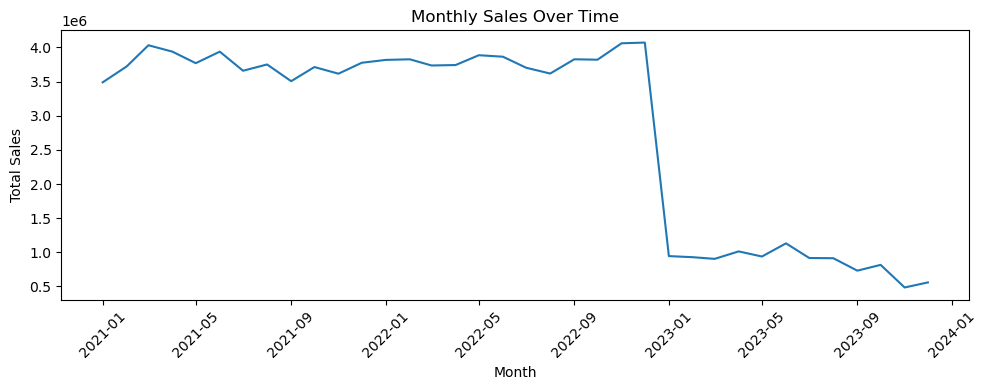

Highest month: 2022-12-01 with 4071496.78
Lowest month: 2023-11-01 with 485230.74


In [49]:
date_series = fct_invoice.dropna(subset=['invoice_date']).copy()
date_series = date_series.set_index('invoice_date')
monthly = date_series['line_total'].resample('MS').sum()

print("Monthly totals preview:")
display(monthly.head(12).to_frame('monthly_sales'))

plt.figure(figsize=(10, 4))
plt.plot(monthly.index, monthly.values)  
plt.title("Monthly Sales Over Time")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

if len(monthly.dropna()):
    top_month = monthly.idxmax()
    low_month = monthly.idxmin()
    print("Highest month:", top_month.date(), "with", float(monthly.max()))
    print("Lowest month:",  low_month.date(),  "with", float(monthly.min()))

## Hard

### Sales by category and decade age range (e.g., 10-19, 20-29, and so forth)

In [50]:
inv_with_age_nonnull = inv_with_age.dropna(subset=['age']).copy()

ages = inv_with_age_nonnull['age'].astype(float)
decade_start = (np.floor(ages / 10) * 10).astype(int)
inv_with_age_nonnull['age_decade'] = decade_start.astype(str) + "-" + (decade_start + 9).astype(str)

pivot_tbl = pd.pivot_table(
    inv_with_age_nonnull,
    values='line_total',
    index='category',
    columns='age_decade',
    aggfunc='sum',
    fill_value=0
)

ordered_cols = sorted(pivot_tbl.columns, key=lambda s: int(s.split("-")[0]))
pivot_tbl = pivot_tbl[ordered_cols]

display(pivot_tbl)

age_decade,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89
category,,,,,,,,
Books,12801.75,79461.75,84143.10,87203.40,74962.20,80476.80,54827.85,26664.00
Clothing,1927413.84,10250732.80,11354126.96,11215189.92,10321851.76,10660642.08,7769371.28,4493698.00
Cosmetics,109619.36,605915.32,723544.70,665034.96,587780.96,649990.76,419082.62,254531.60
Food & Beverage,13582.31,73491.96,87246.86,89553.29,72425.04,80976.09,55050.98,31332.93
Shoes,993281.35,5924878.24,7200839.66,7025590.02,5852857.84,5978893.54,4480269.05,2628744.60
Souvenir,12375.15,54943.32,64092.72,66391.80,54943.32,55025.43,38673.81,23718.06
Technology,1129800.00,5261550.00,6159300.00,5954550.00,4435200.00,5471550.00,3638250.00,1946700.00
Toys,60426.24,385100.80,420582.40,390906.88,345067.52,363955.20,273244.16,153932.80
